# Creation of a dataset with modified pixels so as to simulate the presence of plastic litter

Thanks to state of the art researchers and the begining of our work, we manage to get plastic spectral signature. With this spectral signature, we can easily simulate the presence of plastic pixels in another image, free from plastic. The goal of this notebook is to create such a dataset, centered on the Greek island Mytilene (where the researchers deployed plastic targets) so as to keep the same 'envrionnement' to begin.

The idea of this dataset is to generate labelled data. We will be able to train a model on this dataset, and test it on images where the presence of plastic targets is verified (for exemple, images of the plastic targets of the plastic litter project).

The dataset will be based on a sentinel 2 image (called tile) centered on Mytilene. The idea is to create patches from this tile, with a shape 60x70xN where N is the number of spectral bands. Each patch will be labelled with a mask : 0 where no plastic, and 1 for plastic. 

The dataset will have the foloowing structure : 

data/simplastic/

            - img
                - img1.tif
                - img2.tif
                - ...
            - label
                - label1.tif
                - label2.tif
                - ...
                
It will be uploaded on google drive, make sure you put it on the right folder after downloading it.

## Summary

- #### Part 1 : Get the tiles
Get raw data

- #### Part 2 : Separate water from land
Kmeans

- #### Part 3 : Simulate plastic
Modify some pixels to simulate plastic thank to its spectral signature

- #### Part 4 : resolving problems
Had some problems with the spectral signature of the sea : it is not the same near the coast and at sea

- #### Part 4 : Create Label




In [58]:
## import libraries and utils

import utils
import tifffile
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import os
from tqdm import tqdm
from PIL import Image
import spectral
import sys

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

### Part 1 : get the tiles

As we take images from EO browser, we have several images to process. M1 is the image where plastic targets were deployed. M2 is an image of the same island, but at a different place.

In [59]:
## Load the tile
## we will not use utils get band as having a array is better here 

def get_array(folder):
    
    # we want all the bands to create the dataset
    L = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

    path = 'data/'+ folder
    inside_folder = os.listdir(path)

    # store the bands
    band_array = np.zeros((600,1400,len(L)))

    ## load wanted spectral bands
    i = 0
    for raw_band in inside_folder:
        for desired_band in L:
            if desired_band in raw_band:
                img = tifffile.imread(os.path.join(path,raw_band))
                # crop the image not to have problems when creating patchs
                band_array[:,:,i] = img[:600,:1400]
                i+=1
    return band_array


In [60]:
band_arrayM1 = get_array('Mytilene/M1')
band_arrayM2 = get_array('Mytilene/M2')

## Part 2 : Separate water from land

In [61]:
def kmeans(arrays, nb_clust):
    arrays_flat=np.array([arrays[:,:,i].flatten() for i in range(arrays.shape[2])])
    X=(np.transpose(arrays_flat))
    kmeans = KMeans(n_clusters=nb_clust,  init='k-means++', n_init=10, max_iter=1000) # tester k-means méthod max?
    kmeans.fit(X)
    labels=kmeans.labels_
    plastic_index = 0
    nb = 99999
    nb_2 = 0
    img_labels = labels.reshape(600,1400)
    plt.figure()
    plt.imshow(img_labels)
    
    return img_labels

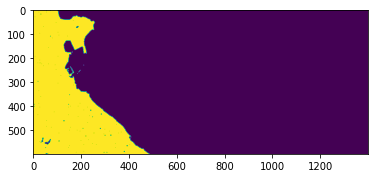

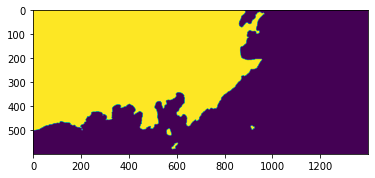

In [72]:
img_labelsM1 = kmeans(band_arrayM1,2)
img_labelsM2 = kmeans(band_arrayM2,2)

The segmentation seems to be good, so now we will just place plastic on the image. 
**Be careful : the land must be labelled 1**

## Part 3 : simulate plastic

In [73]:
plastic_signature = np.array([0.021325, 0.03825 , 0.037625, 0.0334  , 0.022025, 0.024225,
       0.029725, 0.055125, 0.001   , 0.0201  , 0.016775, 0.02935 ])

In [74]:
from random import random
import random as rd
def plastic_or_not_plastic(prob = 0.005):
    n = random()
    if  n < prob:
        plastic = True
    else :
        plastic = False
    return plastic

In [75]:
def alter_plastic_signature(plastic_signature):
    noise = np.random.normal(0,0.0005,12)
    plastic_signature +=  plastic_signature*noise
    return plastic_signature
print(alter_plastic_signature(plastic_signature))

[0.02132146 0.03823203 0.03763078 0.03340272 0.02202971 0.02423293
 0.02971582 0.05508955 0.00100014 0.02008558 0.01680068 0.02933244]


In [76]:
def add_plastic(img,kmeans_label):
    label = np.zeros(img.shape[:2])
    tot = img.shape[0]*img.shape[1]
    nb = 0
    for i in range(0,img.shape[0],4):
        for j in range(0, img.shape[1],4):
            size = rd.choices([1,2,3],weights = [10,2,1], k=2)
            #print(size)
            if kmeans_label[i,j] == 0 :
                if plastic_or_not_plastic() :
                    pix = alter_plastic_signature(plastic_signature)
                    img[i:i+size[0],j:j+size[0],:] = pix
                    label[i:i+size[0],j:j+size[0]] = 1
                    nb+= size[0]*size[1]
                    
    print('Modified pixels = {}/{}'.format(nb,tot) )
                
    return img,label
                

In [77]:
imgM1,labelM1 = add_plastic(band_arrayM1,img_labelsM1)

Modified pixels = 367/840000


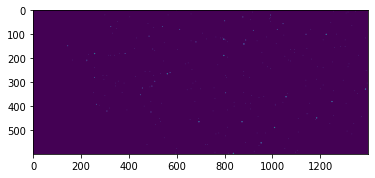

In [78]:
plt.imshow(labelM1)

seems great, now let's plot a spectral band

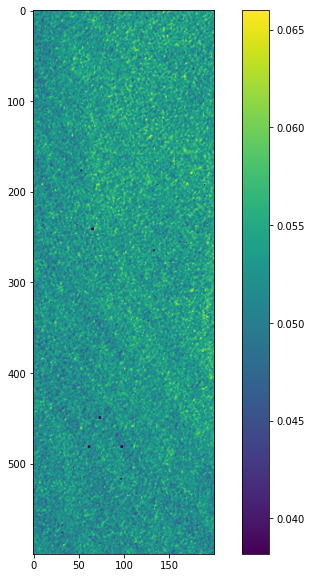

In [83]:
plt.figure(figsize = (10,10))
plt.imshow(imgM1[:,1000:1200,1])
plt.colorbar()

There is a problem, the spectral signature a plastic is a far lower than the seaa signature. The clustering of the other notebook revealed that the spectral signature of plastic was higher of some spectral bands. Maybe the fact that we are at sea must be taken into account. Let's verify it : 

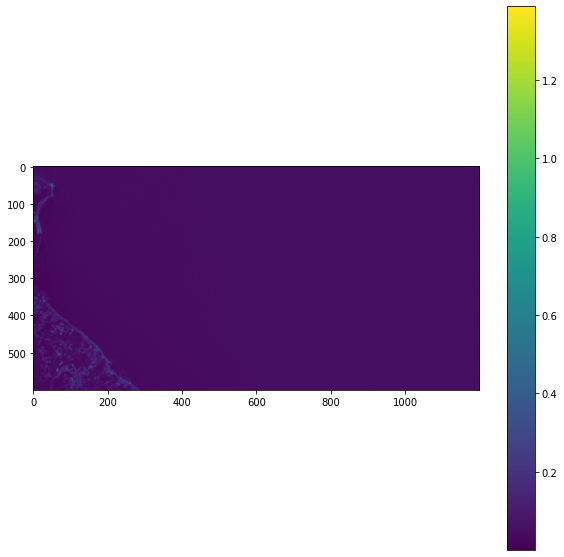

In [79]:
plt.figure(figsize = (10,10))
plt.imshow(band_arrayM1[:,200:,1])
plt.colorbar()

In [47]:
X = [i for i in range(len(band_arrayM1[100:110,250:,1][2]))]

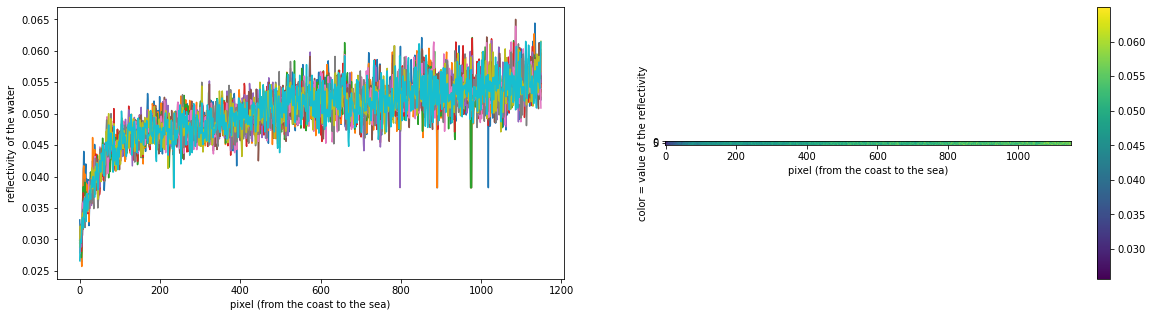

In [87]:
## plot the reflectivity of the water for each spectral band since the coast to the sea (1 line)
plt.figure(1, figsize = (20,5))
plt.subplot(1,2,1)
for i in range(10):
    plt.plot(X, band_arrayM1[100:110,250:,1][i])
plt.xlabel('pixel (from the coast to the sea)')
plt.ylabel('reflectivity of the water')
plt.subplot(1,2,2)
plt.imshow(band_arrayM1[100:110,250:,1])
plt.colorbar()
plt.xlabel('pixel (from the coast to the sea)')
plt.ylabel('color = value of the reflectivity')

plt.show()

As the reflectivity of the plastic change a lot, we can't proceed as we wanted. We need to study now and simulate how plastic would reflect on non coastal areas. Alongside that study, I will create a dataset only on the coastal 

## Part 5 : Create patches

In [129]:
## create folders to store patchs

os.mkdir('data/Mytilene/store_smallImages')
os.mkdir('data/Mytilene/store_smallImages/M1')
os.mkdir('data/Mytilene/store_smallImages/M2')

In [130]:
patch_size = (60,70) 
margin0 = int(patch_size[0]/2)
margin1 = int(patch_size[1]/2)

def create_patchs(band_array,target_folder):
    
    nb = 0 
    for r in range(margin0,600,patch_size[0]):
        for c in range(margin1,1400,patch_size[1]):
            img = band_array[r - margin0:r + margin0 , c - margin1:c + margin1,:]
            tifffile.imsave('data/Mytilene/store_smallImages/{}/img_{}_{}.tif'.format(target_folder,target_folder,str(nb)),img)
            nb+=1


In [131]:
create_patchs(band_arrayM1,'M1')
create_patchs(band_arrayM2,'M2')